NOAA dataset. Eight  features. Two classes.
50 batches of 345 instances



METHOD: Static knn as classifier
Execution time:  0.6815420517364734
Average MCC:  0.314004740626
Average error: 24.0768
Average macro-F1: 0.6041412060010611
Average micro-F1: 0.7412000000000001
Average Accuracy:  75.9232
Standard Deviation:  3.63445756063
Variance:  13.20928176


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


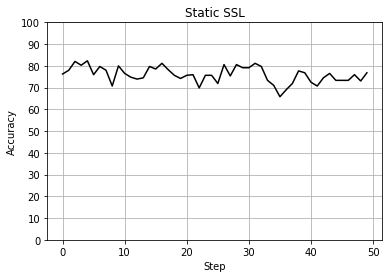

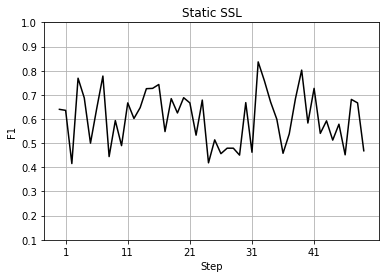

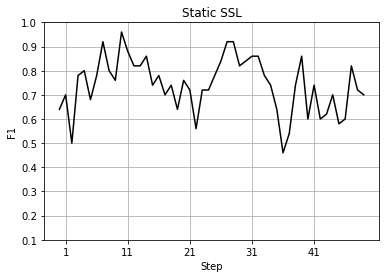




METHOD: Sliding knn as classifier
Execution time:  0.13733011858563215
Average MCC:  0.0119624564466
Average error: 30.979
Average macro-F1: 0.40602956090609366
Average micro-F1: 0.66
Average Accuracy:  69.021
Standard Deviation:  5.02839507199
Variance:  25.284757


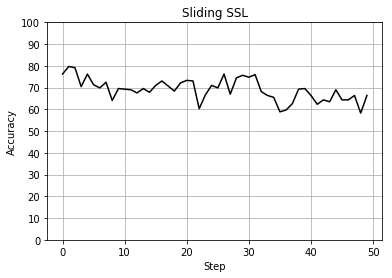

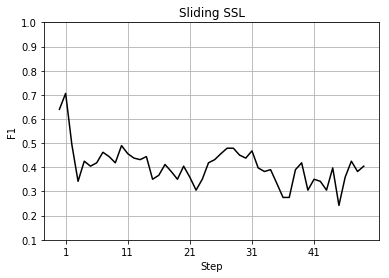

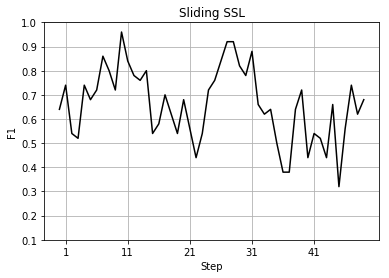




METHOD: Incremental knn as classifier
Execution time:  4.016218067666936
Average MCC:  0.2623699414
Average error: 25.9202
Average macro-F1: 0.550956125371187
Average micro-F1: 0.7228
Average Accuracy:  74.0798
Standard Deviation:  4.27146555177
Variance:  18.24541796


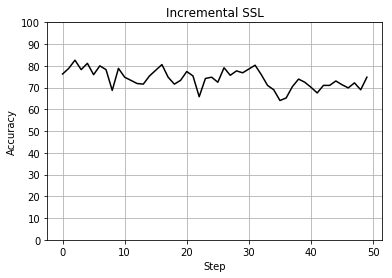

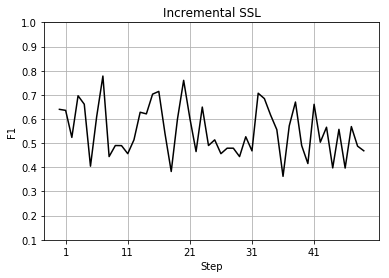

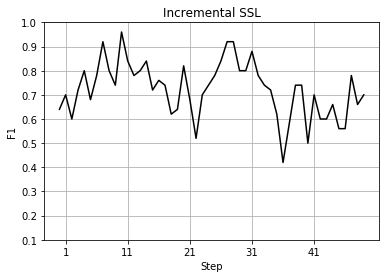




METHOD: knn as classifier and kde as core support extraction with cutting data method
Execution time:  2.3746503211257988
Average MCC:  0.39440953489
Average error: 23.6242
Average macro-F1: 0.6790278048006386
Average micro-F1: 0.7612000000000001
Average Accuracy:  76.3758
Standard Deviation:  3.20250844808
Variance:  10.25606036


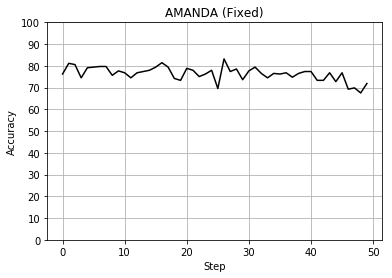

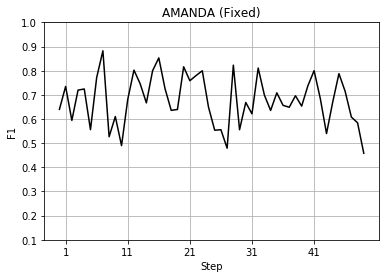

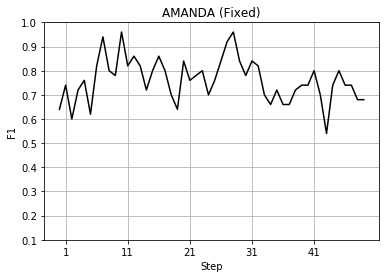




METHOD: knn as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  341.00007150614454
Average MCC:  0.289583285867
Average error: 25.7116
Average macro-F1: 0.6029097026376401
Average micro-F1: 0.7303999999999999
Average Accuracy:  74.2884
Standard Deviation:  3.60397911204
Variance:  12.98866544


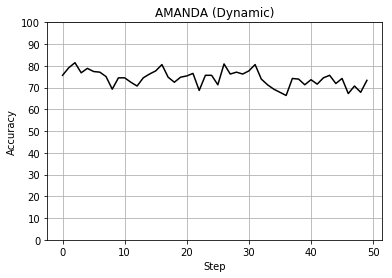

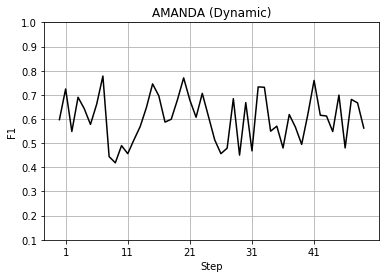

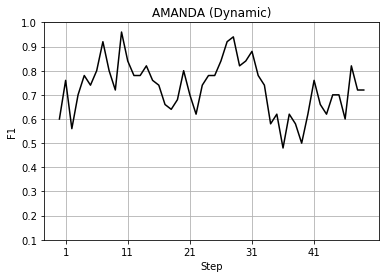




METHOD: None as classifier and GMM with BIC and Mahalanobis as core support extraction
Execution time:  8.282087789792456
Average MCC:  0.0
Average error: 31.402
Average macro-F1: 0.39071961829664864
Average micro-F1: 0.6552
Average Accuracy:  68.598
Standard Deviation:  4.57420987713
Variance:  20.923396


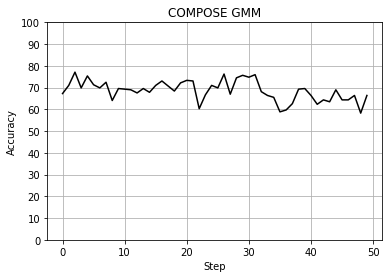

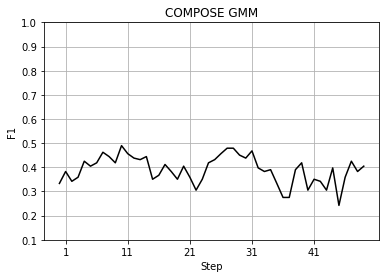

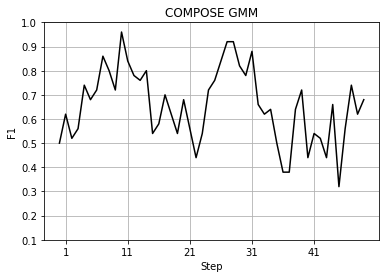




Method: Level IW
Execution time:  8.282087789792456
Average MCC:  -0.0227921812613
Average macro-F1: 0.47456921288562315
Average micro-F1: 0.5616000000000001
Average Accuracy:  68.753622
Standard Deviation:  4.53435420739
Variance:  20.5603680781


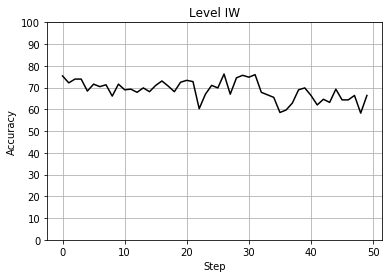

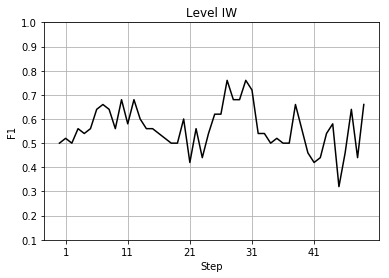

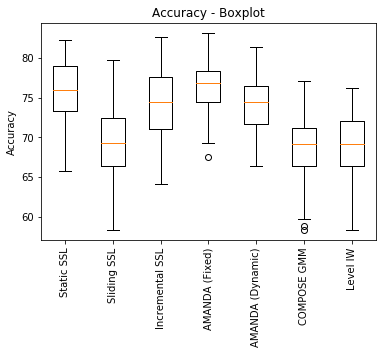

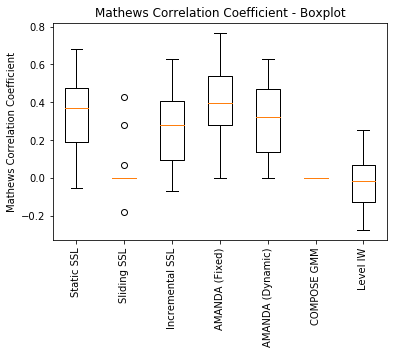

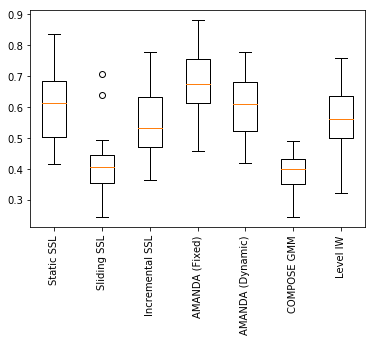

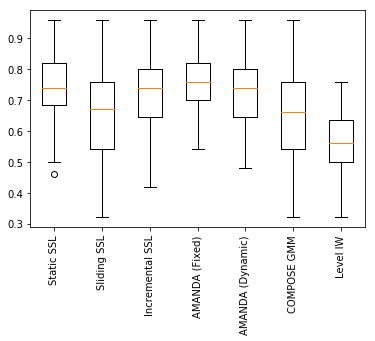

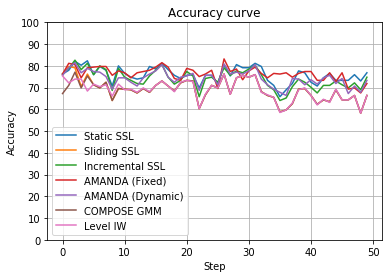

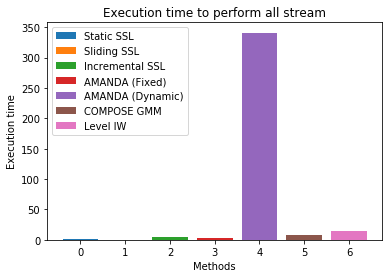

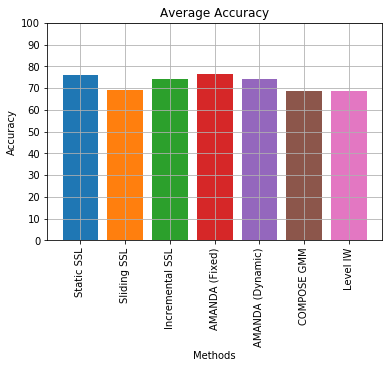

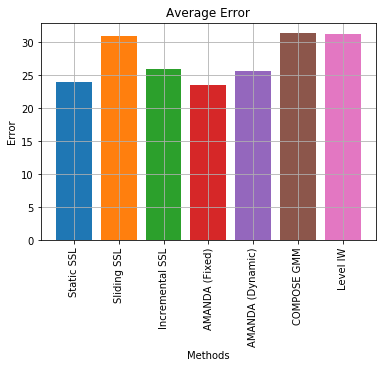

Error reduction: -9.09102882913
Error reduction: -2.42797985333
Error reduction: 0.596128719548
Error reduction: -2.15322852567
Error reduction: -9.64817078311
Error reduction: -9.4431978631


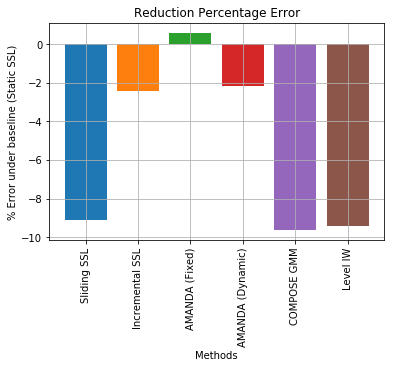

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'knn' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 50
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadNOAADataset(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 8, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 8, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 8, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 8, 0.7, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)

    # COMPOSE GMM (Python version)
    experiments[5] = Experiment(compose_gmm_version, 8)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'noaa', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()